# Aprendizaje Automático
# Tarea 2 - Modelado

Profesor: Felipe Meza

Tecnológico de Costa Rica, 

Programa Ciencia de Datos

---

Estudiantes:

1. Sophia Contreras
2. Yoksan Varela
3. Mauro Víquez

Lista de las librerias por ser usadas:

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import keras
from random import randrange
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from matplotlib import style
style.use('ggplot')
%matplotlib inline

## Problema por resolver
Modelar la calidad del vino de tinto del norte de Portugal, solamente basandose en resultados de las pruebas fisico quimicas de los mismos. El dataset original se encuentra en el siguiente enlance: https://archive.ics.uci.edu/dataset/186/wine+quality

### Primera Parte: Analisis exploratorio y pre-procesado de set de datos

Inicialmente, se importa el set de datos con las informacion de los vinos tintos del estudio (el .csv en uso se va a importar desde una copia local en GitHub)

In [30]:
redWine_dataset = pd.read_csv("https://raw.githubusercontent.com/YoksanVC/TEC_DataScienceCert/main/Module_2_AprendizajeAutomatico/Tarea2/Datasets/winequality-red.csv", header=0, delimiter=';')
redWine_dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Analizando la forma del set de datos con el que vamos a trabajar:

In [31]:
redWine_dataset.shape

(1599, 12)

Se cuenta con 1599 instancias y 12 atributos. Verificando que no hayan valores nulos en el set de datos antes de continuar con el analisis exploratorio:

In [32]:
redWine_dataset.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Se confirma que no tenemos valores Nulos que tengamos que trabajar. Ahora, verifiquemos que todas la instancias en un formato numerico intepretable por los modelos.

In [33]:
for instancia in redWine_dataset:
    print(f"El tipo del atributo {instancia} es {redWine_dataset[instancia].dtype}")

El tipo del atributo fixed acidity es float64
El tipo del atributo volatile acidity es float64
El tipo del atributo citric acid es float64
El tipo del atributo residual sugar es float64
El tipo del atributo chlorides es float64
El tipo del atributo free sulfur dioxide es float64
El tipo del atributo total sulfur dioxide es float64
El tipo del atributo density es float64
El tipo del atributo pH es float64
El tipo del atributo sulphates es float64
El tipo del atributo alcohol es float64
El tipo del atributo quality es int64


Todas la instancias son de tipo flotante o integer, por lo que no es necesario hacer un remapeo y no habra problema con los algoritmos. Como lo que interesa es modelar la calidad de los vinos, nuestras clases va a ser la columna "quality". Veamos su distribucion:

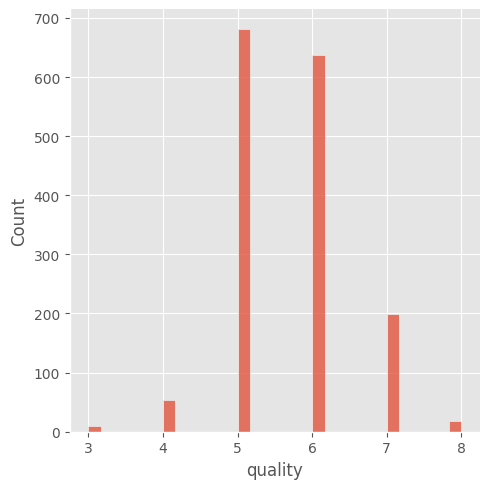

In [34]:
sns.displot(redWine_dataset, x="quality")

Con esta distribucion se nota un problema: hay un desbalance entre la calidad de los vinos, ya que se tienen muchos datos de calidad entre 5 y 6 pero pocos de los demas. Se procede a balancear los datos para tener una distribucion mas balanceada entre la calidad; pero antes de empezar con esta parte, se procede a Normalizar (dado que hay una variacion considerable entre los atributos) y Estandarizar (para centrarlos) los datos.

In [35]:
# Guarda la última columna
last_column = redWine_dataset.iloc[:, -1]

# Elimina la última columna antes de la normalización y estandarización
redWine_dataset = redWine_dataset.iloc[:, :-1]

# Normalización, limitando a 6 decimales
for instancia in redWine_dataset:
    minValue = redWine_dataset[instancia].min()
    maxValue = redWine_dataset[instancia].max()
    redWine_dataset[instancia] = (((redWine_dataset[instancia] - minValue) / (maxValue - minValue))).round(6)

# Estandarización, limitando a 6 decimales
for instancia in redWine_dataset:
    mean = np.mean(redWine_dataset[instancia])
    std = np.std(redWine_dataset[instancia])
    redWine_dataset[instancia] = ((redWine_dataset[instancia] - mean) / (std)).round(6)

# Vuelve a agregar la última columna
redWine_dataset = pd.concat([redWine_dataset, last_column], axis=1)

redWine_dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528357,0.961875,-1.391472,-0.453220,-0.243703,-0.466194,-0.379132,0.558277,1.288642,-0.579203,-0.960247,5
1,-0.298546,1.967443,-1.391472,0.043413,0.223880,0.872636,0.624366,0.028259,-0.719932,0.128951,-0.584775,5
2,-0.298546,1.297064,-1.186070,-0.169431,0.096354,-0.083671,0.229044,0.134267,-0.331176,-0.048087,-0.584775,5
3,1.654857,-1.384444,1.484154,-0.453220,-0.264964,0.107590,0.411503,0.664277,-0.979103,-0.461177,-0.584775,6
4,-0.528357,0.961875,-1.391472,-0.453220,-0.243703,-0.466194,-0.379132,0.558277,1.288642,-0.579203,-0.960247,5


Veamos cual es la cuenta exacta por valor en la columna de calidad:

In [36]:
print(redWine_dataset['quality'].value_counts())

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


Hay 3 calidades que tienen muchos datos: 5, 6 y 7. Se procede a crear una funcion que recibe como parametros: un dataframe (obligatorio), el valor con el que se desea hacer el filtro (obligatorio) y la cantidad total de isntancias deseadas con el fin de realizar un sub-muestreo de esos valores (opcional con un valor por defecto de 100).

In [37]:
def subsampling(dataframe_ori, filter, sampling_limit=100):
    dataframe = dataframe_ori.copy()
    limit_counter = 0
    for i in range(dataframe.shape[0]):
        if (dataframe['quality'][i] == filter):
            if (limit_counter < sampling_limit):
                randNumber = randrange(1,10)
                if (dataframe.loc[i,'quality'] == filter and randNumber <= 4): # Probabilidad de un 40% de mantenerse
                    limit_counter += 1
                else:
                    dataframe.loc[i,'quality'] = pd.NA
            else:
                dataframe.loc[i,'quality'] = pd.NA
    return dataframe


Creando una copia del set datos para conservar los datos originales:

In [38]:
redWine_dataset_trimmed = redWine_dataset.copy()
redWine_dataset_trimmed.shape

(1599, 12)

Se realiza el sub-muestreo con la funcion subsampling y verificamos la cantidad de datos final:

In [39]:
# Sub-muestreo usando la fincion de subsampling
redWine_dataset_trimmed = subsampling(redWine_dataset_trimmed,5,120)
redWine_dataset_trimmed = subsampling(redWine_dataset_trimmed,6,120)
redWine_dataset_trimmed = subsampling(redWine_dataset_trimmed,7,100)

# Removiendo todos los NaN
redWine_dataset_trimmed.dropna(inplace=True)

redWine_dataset_trimmed.shape

(414, 12)

Ahora, hacemos histograma para confirmar que se alcanzado un mejor balance; aunque cabe la pena rescatar que pasamos de mas de 1000 instancias a 368, lo cual podria provocar un problema de under-fitting.

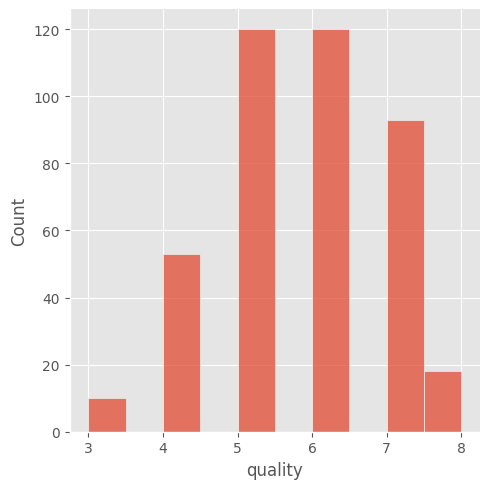

In [40]:
sns.displot(redWine_dataset_trimmed, x="quality")

Se confirma que se tiene un mejor balance. Ya con esto completo, vamos a hacer una revision de los atributos. Hay 12 atributos por analizar, por lo que deberiamos hacer un descarte de algunos para simplificar el modelo. Vamos a crear 3 nuevos data sets, con 4 atributos cada uno, para luego analizar las densidades de cada grupo (lo hacemos con densidades para no hacer una comparacion de datos directa dado que las cantidades son distintas):

In [41]:
df_grupo1 = redWine_dataset_trimmed[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar']]
df_grupo2 = redWine_dataset_trimmed[['chlorides', 'free sulfur dioxide','total sulfur dioxide', 'density']]
df_grupo3 = redWine_dataset_trimmed[['pH', 'sulphates','alcohol']]

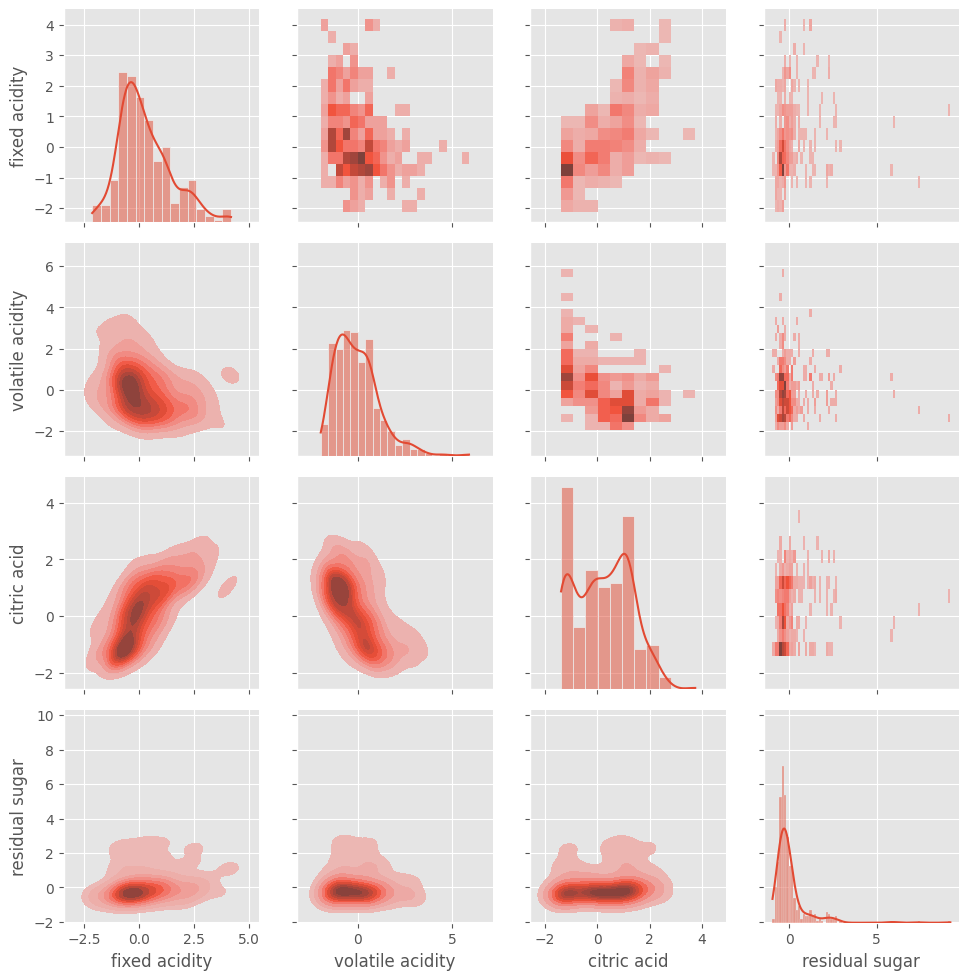

In [42]:
g = sns.PairGrid(df_grupo1)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

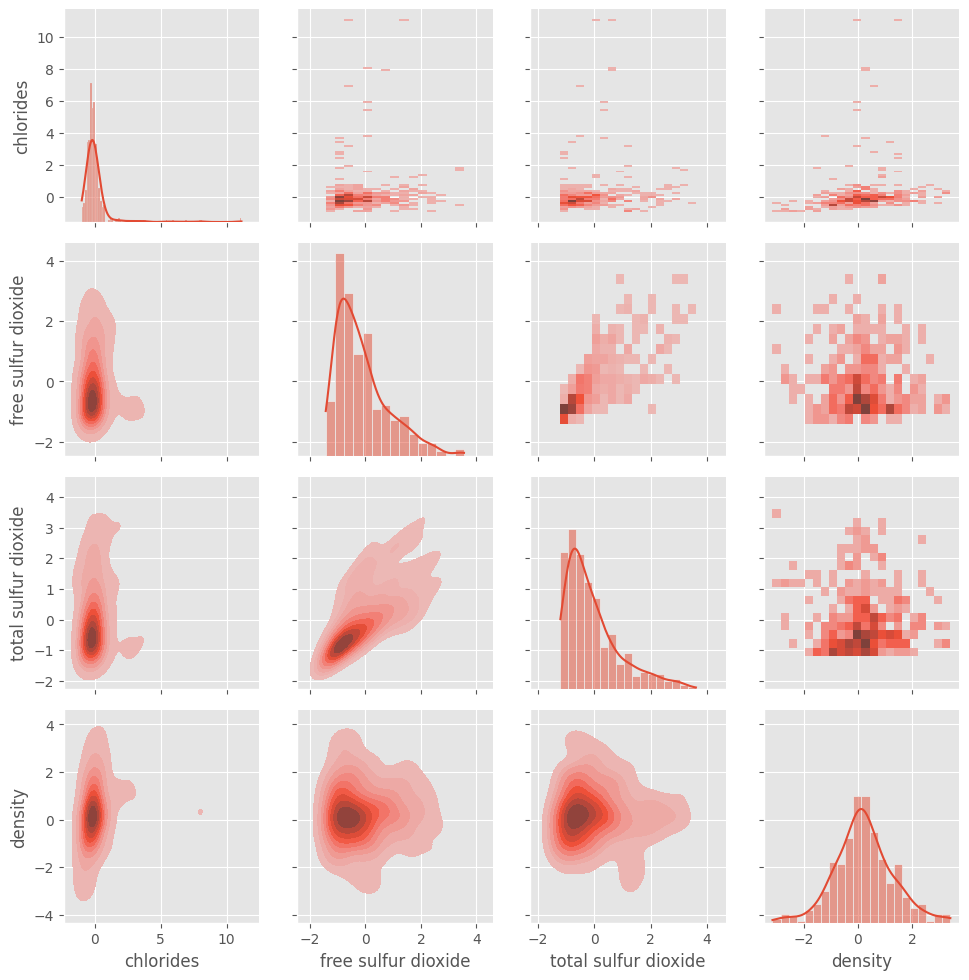

In [43]:
g = sns.PairGrid(df_grupo2)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

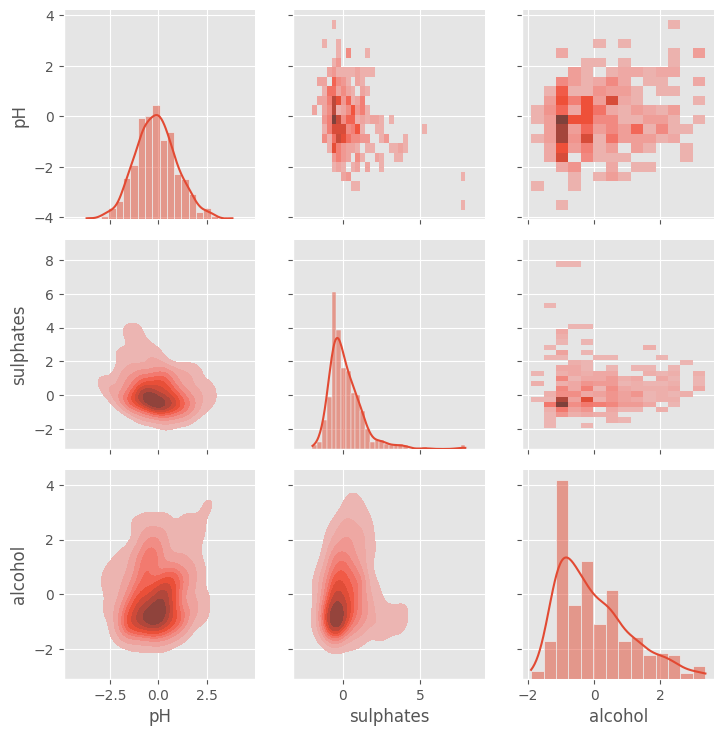

In [44]:
g = sns.PairGrid(df_grupo3)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

Despues de analizar cada grupo, podemos llegar a las siguientes conclusiones:
- El set de datos fue sometido a un sub-muestredo de la calidad, la cual sigue una distribucion normal. Algunos de los atributos no siguen una distribucion normal, tienen skewness muy pronunciados hacia la derecha, lo cual sugiere que esos atributos no podrian ser afectar mucho la calidad del vino.
- Otros atributos si muestran una distribucion bastante normal, lo que los convierte en candidatos para poder usados en el modelo de regresion.

Por lo tanto, los atributos seleccionados para crear el modelo son: *fixed acidity, volatile acidity, density, pH y alcohol*

### Segunda Parte: Modelado y medicion de rendimiento del modelo

Lo primero es crear el set de datos con los atributos seleccionados:

In [45]:
redWine_dataset_toModel = redWine_dataset_trimmed[['fixed acidity', 'volatile acidity','density','pH','alcohol','quality']]
redWine_dataset_toModel.shape

(414, 6)

In [46]:
redWine_dataset_toModel.head(10)

,fixed acidity,volatile acidity,density,pH,alcohol,quality
0,-0.528357,0.961875,0.558277,1.288642,-0.960247,5.0
4,-0.528357,0.961875,0.558277,1.288642,-0.960247,5.0
5,-0.528357,0.738418,0.558277,1.288642,-0.960247,5.0
10,-0.930529,0.291495,-0.448751,-0.201591,-1.147981,5.0
13,-0.298546,0.459090,0.346268,-0.331176,-1.241850,5.0
14,0.333436,0.514961,0.982287,-0.979103,-1.147981,5.0
15,0.333436,0.514961,0.982287,-0.914310,-1.147981,5.0
16,0.103626,-1.384444,0.081259,-0.072005,0.072294,7.0
17,-0.126185,0.179771,0.028259,-1.303067,-1.054111,5.0
18,-0.528357,0.347366,0.346268,0.446337,-1.335714,4.0


Separemos los atributos y la clase:

In [47]:
atributos = redWine_dataset_toModel[['fixed acidity', 'volatile acidity','density','pH','alcohol']]
clase = keras.utils.to_categorical(redWine_dataset_toModel['quality'])

In [48]:
atributos.head()

,fixed acidity,volatile acidity,density,pH,alcohol
0,-0.528357,0.961875,0.558277,1.288642,-0.960247
4,-0.528357,0.961875,0.558277,1.288642,-0.960247
5,-0.528357,0.738418,0.558277,1.288642,-0.960247
10,-0.930529,0.291495,-0.448751,-0.201591,-1.147981
13,-0.298546,0.459090,0.346268,-0.331176,-1.241850


In [49]:
print(clase[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [50]:
from sklearn.model_selection import train_test_split
#se procede a dividir los datos en una proporción de 75/25
X_train, X_test, y_train, y_test = train_test_split(atributos,clase, test_size=0.5)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('Size of Train Data: ' + str(len(X_train)))
print('Size of Test Data: ' + str(len(X_test)))

Size of Train Data: 207
Size of Test Data: 207


In [51]:
# Creando ANN - Librerias
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.metrics import Accuracy

# Creacion del modelo
ann_model = Sequential()

ann_model.add(Dense(128,input_dim=5))
ann_model.add(Activation('tanh'))

ann_model.add(Dense(64))
ann_model.add(Activation('tanh'))

ann_model.add(Dense(9))
ann_model.add(Activation('sigmoid'))

# Compilando el modelo
ann_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ann_model.summary()

c:\Users\varely1\AppData\Local\anaconda3\envs\ML_NN\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │           585 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,609 (37.54 KB)

 Trainable params: 9,609 (37.54 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Entrenamiento del modelo
ann_model.fit(X_train, y_train, epochs=200, batch_size=50, verbose=1)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1291 - loss: 2.1286  
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3674 - loss: 1.8890 
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4738 - loss: 1.7074 
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4854 - loss: 1.6388 
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5123 - loss: 1.5634 
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5320 - loss: 1.4924 
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5073 - loss: 1.4512 
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4897 - loss: 1.4606 
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5092 - loss: 1.3927 
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5043 - loss: 1.3944 
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5024 - loss: 1.3808 
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.5271 - 

In [53]:
# Viendo los scores
score = ann_model.evaluate(X_train,y_train)
print(f"Training Accuracy: {score[1]}")

score = ann_model.evaluate(X_test,y_test)
print(f"Test Accuracy: {score[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6968 - loss: 0.7310  
Training Accuracy: 0.6908212304115295
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4395 - loss: 1.4867 
Test Accuracy: 0.43478259444236755


Hay overfitting, regulando:

In [61]:
# Creacion del modelo con Dropout
ann_model = Sequential()

ann_model.add(Dense(128,input_dim=5))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.3))

ann_model.add(Dense(64))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.3))

ann_model.add(Dense(32))
ann_model.add(Activation('tanh'))
ann_model.add(Dropout(0.3))

ann_model.add(Dense(32))
ann_model.add(Activation('sigmoid'))
ann_model.add(Dropout(0.3))

ann_model.add(Dense(9))
ann_model.add(Activation('sigmoid'))

# Compilando el modelo
ann_model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

ann_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 9)              │           297 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,457 (48.66 KB)

 Trainable params: 12,457 (48.66 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
ann_model.fit(X_train, y_train, epochs=300, batch_size=50, verbose=1)

Epoch 1/300


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 2.6253  
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 2.3350 
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.0000e+00 - loss: 2.1523  
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0768 - loss: 1.9686 
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1645 - loss: 1.8348 
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1894 - loss: 1.7841 
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3346 - loss: 1.6811 
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3770 - loss: 1.6355 
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.4590 - loss: 1.5515
Epoch 10/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4906 - loss: 1.5238 
Epoch 11/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4478 - loss: 1.4834 
Epoch 12/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.4862 - lo

In [60]:
# Viendo los scores
score = ann_model.evaluate(X_train,y_train)
print(f"Training Accuracy: {score[1]}")

score = ann_model.evaluate(X_test,y_test)
print(f"Test Accuracy: {score[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5674 - loss: 0.9071 
Training Accuracy: 0.5700483322143555
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4734 - loss: 1.5992 
Test Accuracy: 0.5169082283973694
